In [1]:
# !pip install -e ./task_model 
# !pip install tensorflow-addons

In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, BinaryCrossentropy
from tensorflow.keras.losses import binary_crossentropy as bce_loss
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient

from task_model.task_unet_model import MobileNetV2_UNet as unet_model
from sklearn.metrics import precision_score, recall_score

import json
from skimage import io, morphology
from pathlib import Path
from datetime import datetime

In [35]:
# set some base variables up
DEFAULT_IMAGE_SIZE = [512, 512, 3]
DEFAULT_BATCH = 8
DEFAULT_NUM_CLASSES = 2

# designate model name identifier, if any
DEFAULT_SAVE_MODEL = True
model_savebase = 'base_model_SigFocalCE_'

# set some path variables up
base_dir = Path('C:/Users/NPDan/Documents/GitHub/task_challenge/data')

# force cpu for testing, Omit for train
# tf.config.set_visible_devices([], 'GPU')

# set seed for RNG
tf.random.set_seed(4321)


In [29]:
datetime.now().strftime('%Y%m%d-%H%M%S')

'20210408-192339'

In [4]:
# pull in the dataset dataframes
train_df_path = base_dir / 'train_df.json'
with open(train_df_path, 'r') as fp:
    train_df = pd.read_json(fp)
valid_df_path = base_dir / 'valid_df.json'
with open(valid_df_path, 'r') as fp:
    valid_df = pd.read_json(fp)
test_df_path = base_dir / 'test_df.json'
with open(test_df_path, 'r') as fp:
    test_df = pd.read_json(fp)

That APPEARS to be what we want, we ended up going with a weighted dice coef loss (tversky)

Let's calculate some class weights to use

In [5]:
def make_boundary(y, width=2):
    # should handle 2d and 3d cases
    y_bd = morphology.dilation(np.squeeze(y), morphology.square(width * 2 + 1))
    return y_bd.reshape(y.shape) - y

In [6]:
foreground_frac, background_frac, boundary_frac = 0, 0, 0

for mask_path in train_df['local_mask']:
    # load base mask
    base_mask = io.imread(Path(mask_path)) / 255.
    # dilate to find boundary
    boundary_mask = 0 # 2 class problem only - make_boundary(base_mask)
    # define background as everything else
    background_mask = np.ones_like(base_mask) - boundary_mask - base_mask
    
    # count them up
    foreground_frac += base_mask.flatten().sum()
    # boundary_frac += boundary_mask.flatten().sum()
    background_frac += background_mask.flatten().sum()

# find most common class, divide
max_class = np.max([foreground_frac, boundary_frac, background_frac])
foreground_frac /= max_class
boundary_frac /= max_class
background_frac /= max_class

print(f'Weights - FG: {foreground_frac:.3f}  BD: {boundary_frac:.3f}  BG: {background_frac:.3f}')
DEFAULT_SAMPLE_WEIGHTS = None # 1 /  np.array([foreground_count, boundary_count, background_count]).astype('float32')

Weights - FG: 0.270  BD: 0.000  BG: 1.000


In [7]:
# let's reuse our janky image read methods to parse in our x, y paths
def read_data(path, float_convert=True, scale_fctr=255., return_3D=True):
    # type enforcement for consistency
    if not isinstance(path, (Path, str)):
        path = path.decode()
    if float_convert:
        data = _read_float(path, scale_fctr)
    else:
        data = _read_u8(path, scale_fctr)
    if return_3D:
        data = np.atleast_3d(data)
    return data

def _read_float(path, scale_fctr=1.):
    x = io.imread(path) / scale_fctr
    return x.astype('float32') 

def _read_u8(path, scale_fctr=1):
    x = io.imread(path) / scale_fctr
    return x.astype('uint8')

In [8]:
# let's get our datasets
def tf_parse(x, y, image_size=DEFAULT_IMAGE_SIZE[0], num_classes=DEFAULT_NUM_CLASSES):
    def _parse(x, y):
        x = read_data(x, True)
        y = read_data(y, True, 255.)
        if num_classes == 3:
            # dilate mask to make boundary, concatenate result
            y_bd = np.atleast_3d(make_boundary(y))
            y = np.concatenate((y, y_bd), axis=2)
        if num_classes > 1:
            # define bg as absence of other classes, concatenate result
            y_bg = np.atleast_3d(np.logical_not(np.any(y > 0, axis=2)))
            y = np.concatenate((y, y_bg), axis=2)
        return x, y
    
    # NOTE: need to be careful, not 100% what these are doing
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([image_size, image_size, 3])
    y.set_shape([image_size, image_size, num_classes])
    return x, y

def tf_dataset(x, y, batch=DEFAULT_BATCH):
    # duplicate sample_weights to match full dataset size... Ugh...
    # define dataset size, map parse function, batch and allow repeat loop    
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [9]:
# get our path vectors
image_key, mask_key, test_valid_key = 'local_image', 'local_mask', 'building'
train_x, train_y = sorted(train_df[image_key].to_list()), sorted(train_df[mask_key].to_list())

# grab the 'augmented' validation and test sets
valid_y = sorted([str(p) for p in Path(valid_df[test_valid_key].to_list()[0]).glob('*.png')])
valid_x = [str(p).replace('masks', 'images') for p in valid_y]
test_y = sorted([str(p) for p in Path(test_df[test_valid_key].to_list()[0]).glob('*.png')])
test_x = [str(p).replace('masks', 'images') for p in test_y]

# get our tf datasets
train_dataset = tf_dataset(train_x, train_y, batch=DEFAULT_BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=DEFAULT_BATCH)
test_dataset = tf_dataset(test_x, test_y, batch=DEFAULT_BATCH)

In [10]:
# sanity check, is our data the right shape
train_dataset.element_spec, len(test_x) # Huzzah!


((TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 512, 512, 2), dtype=tf.float32, name=None)),
 735)

Let's continue using dice coef as the loss function

In [11]:
DEFAULT_SMOOTH_EPS = 1e-7 # avoid divide by zero issues
DEFAULT_F_BETA = 0.25
def dice_coef(y_true, y_pred, smooth=DEFAULT_SMOOTH_EPS):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    # apply weights to 
    
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# https://github.com/keras-team/keras/issues/9395#issuecomment-379276452
def dice_coef_multilabel(y_true, y_pred, class_weights):
    # Since TF is cuckoo and doesn't support a proper weights function (?!)
    # image segmentatnoi model, let's do it here
    dice_score = 0
    for index in range(len(class_weights)):
        dice_score += dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index]) * class_weights[index]
    return dice_score

def dice_loss_multilabel(y_true, y_pred, class_weights=DEFAULT_SAMPLE_WEIGHTS):
    # compute max score, subtract dice score
    base_score = tf.ones_like(class_weights) * class_weights
    return base_score - dice_coef(y_true, y_pred, class_weights)


# well, the above multilabel was doing some funky stuff, so let's just do teh 2-class tversky loss
def tversky_loss(y_true, y_pred, beta=foreground_frac, smooth=DEFAULT_SMOOTH_EPS):
    # beta factor emphasizes false-negatives -> (1 - beta) * y_true * (1 - y_pred)
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    numerator = y_true * y_pred
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred) 
    return 1. - tf.reduce_sum(numerator + smooth) / tf.reduce_sum(denominator + smooth)

# possible weighted bce loss option
def mod_bce_loss(y_true, y_pred, from_logits=True, label_smoothing=0.1):
    return bce_loss(y_true, y_pred, from_logits, label_smoothing)

# modified f1 score - optimizes precision and recall
# https://en.wikipedia.org/wiki/F-score - beta = .5 ->  2x weight precision
def f_beta(y_true, y_pred, beta=DEFAULT_F_BETA, smooth=DEFAULT_SMOOTH_EPS):
    beta *= beta
    beta_coef = 1 + beta
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    tp = tf.reduce_sum(y_true * y_pred)
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return (beta_coef * tp + smooth) / (beta_coef * tp + beta * fn + fp + smooth)

Moment of truth... let's instantiate our optimizer and callbacks and start fittin'

In [12]:
# setting monitor = loss should track the training loss, but for reference I've duplicated the
# training data as validation set
# changing patience to hopefully expediite memorization
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False, min_delta = 0.0001),
]

# SET training steps - validation data includes auto-augmentations
train_steps = len(train_x)//DEFAULT_BATCH
valid_steps = len(valid_x)//DEFAULT_BATCH
if len(train_x) % DEFAULT_BATCH != 0:
    train_steps += 1
if len(valid_x) % DEFAULT_BATCH != 0: 
    valid_steps += 1

In [13]:
model = unet_model(num_classes=DEFAULT_NUM_CLASSES)
# model.summary()

In [14]:
DEFAULT_LR = 0.1
DEFAULT_EPOCHS = 100
opt = tf.keras.optimizers.Adam(DEFAULT_LR)
metrics = [
    Recall(),
    Precision(),
    #MatthewsCorrelationCoefficient(num_classes=DEFAULT_NUM_CLASSES, name='MCC')
]
model.compile(loss=  SigmoidFocalCrossEntropy(alpha=0.25),
              optimizer=opt,
              metrics=metrics
             )

In [15]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=DEFAULT_EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks,
)

Epoch 1/100
21/21 [==============================] - 30s 963ms/step - loss: 0.1372 - recall: 0.6037 - precision: 0.7624 - val_loss: 3.0674 - val_recall: 0.7995 - val_precision: 0.7995
Epoch 2/100
21/21 [==============================] - 16s 786ms/step - loss: 0.0903 - recall: 0.5101 - precision: 0.9377 - val_loss: 3.0674 - val_recall: 0.7995 - val_precision: 0.7995
Epoch 3/100
21/21 [==============================] - 16s 780ms/step - loss: 0.0733 - recall: 0.6217 - precision: 0.9553 - val_loss: 2.9000 - val_recall: 0.7995 - val_precision: 0.7995
Epoch 4/100
21/21 [==============================] - 16s 776ms/step - loss: 0.0630 - recall: 0.6779 - precision: 0.9534 - val_loss: 1.3087 - val_recall: 0.7995 - val_precision: 0.7995
Epoch 5/100
21/21 [==============================] - 16s 777ms/step - loss: 0.0595 - recall: 0.6926 - precision: 0.9535 - val_loss: 0.2961 - val_recall: 0.6531 - val_precision: 0.7775
Epoch 6/100
21/21 [==============================] - 16s 778ms/step - loss: 0.05

In [17]:
def visualize_image_and_mask(x_img, y_true=None, y_pred=None,
                             mask_cmap_name='winter', show_axis=False, title_prefix = ''):
    # plot original
    fig = plt.figure()
    plt.subplot(1,2,1)
    if y_true is not None:
        # overlay mask if applicable
        y_true = y_true.squeeze()
        plt.title(' '.join((title_prefix, 'Image + Truth')))
        plt.imshow(x_img, vmin=0, vmax=1)
        plt.imshow(y_true, alpha=0.4*y_true, vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
    else:
        plt.title(' '.join((title_prefix, 'Image')))
        plt.imshow(x_img)
    if not show_axis:
        plt.axis('off')
        
    # plot augmented
    if y_pred is not None:
        plt.subplot(1,2,2)
        # overlay mask if applicable
        y_pred = y_pred.squeeze()
        plt.title(' '.join((title_prefix, 'Image + Predicted')))
        plt.imshow(x_img, vmin=0, vmax=1)
        plt.imshow(y_pred, alpha=0.4*y_pred.squeeze(), vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
        if not show_axis:
            plt.axis('off')
    plt.show()


MeanIoU: 0.263  Precision: 0.676  Recall: 0.300


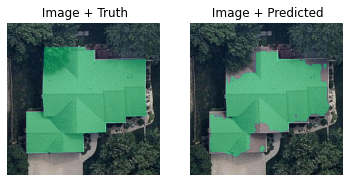

MeanIoU: 0.794  Precision: 0.992  Recall: 0.800


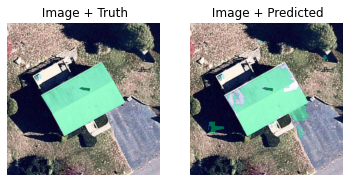

MeanIoU: 0.765  Precision: 0.862  Recall: 0.871


MeanIoU: 0.447  Precision: 0.578  Recall: 0.665


MeanIoU: 0.443  Precision: 0.630  Recall: 0.599


MeanIoU: 0.502  Precision: 0.604  Recall: 0.748


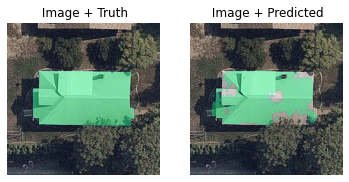

MeanIoU: 0.784  Precision: 0.980  Recall: 0.797


MeanIoU: 0.670  Precision: 0.994  Recall: 0.672


MeanIoU: 0.917  Precision: 0.970  Recall: 0.943


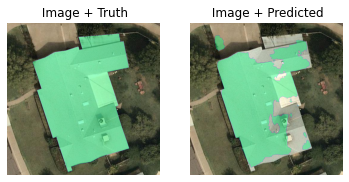

MeanIoU: 0.719  Precision: 0.978  Recall: 0.730


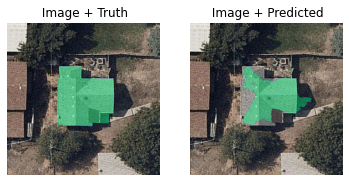

MeanIoU: 0.653  Precision: 0.927  Recall: 0.688


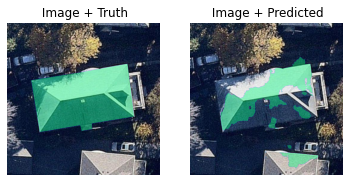

MeanIoU: 0.437  Precision: 0.849  Recall: 0.474


MeanIoU: 0.917  Precision: 0.961  Recall: 0.952


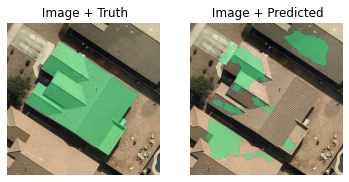

MeanIoU: 0.161  Precision: 0.396  Recall: 0.214


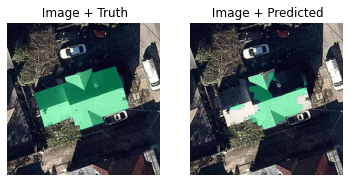

MeanIoU: 0.450  Precision: 0.974  Recall: 0.456


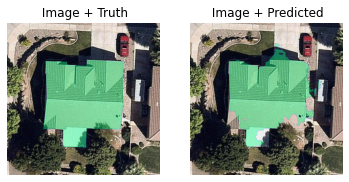

MeanIoU: 0.816  Precision: 0.924  Recall: 0.875


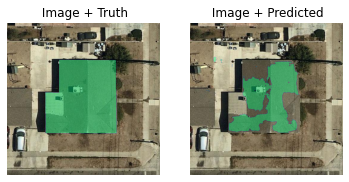

MeanIoU: 0.568  Precision: 0.993  Recall: 0.571


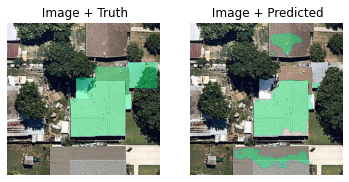

MeanIoU: 0.464  Precision: 0.684  Recall: 0.591


MeanIoU: 0.336  Precision: 0.936  Recall: 0.344


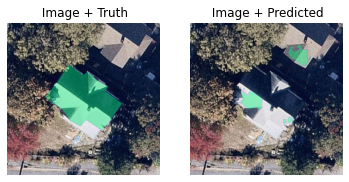

MeanIoU: 0.115  Precision: 0.563  Recall: 0.126


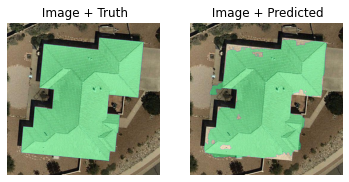

MeanIoU: 0.913  Precision: 0.975  Recall: 0.935


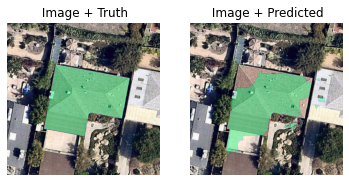

MeanIoU: 0.742  Precision: 0.888  Recall: 0.818


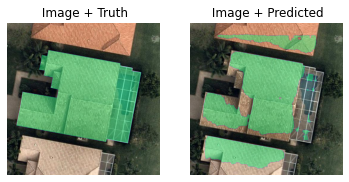

MeanIoU: 0.495  Precision: 0.676  Recall: 0.649


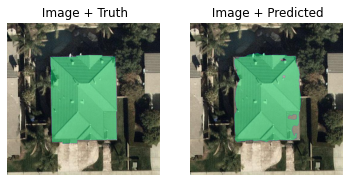

MeanIoU: 0.919  Precision: 0.980  Recall: 0.937


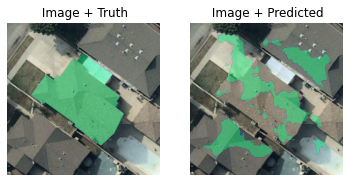

MeanIoU: 0.235  Precision: 0.374  Recall: 0.388
Final MeanIoU:   0.585
Final Precision: 0.820
Final Recall:    0.661


In [18]:
# Run inference on CPU

# let's check the output
avg_MIOU, avg_prec, avg_rec, avg_f1 = [], [], [], []
for ii, (x, y) in enumerate(zip(test_x, test_y)):
    x = read_data(Path(x), True)
    y = read_data(Path(y), True, 255., False)>0
    with tf.device('/cpu:0'):
        y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    y_pred = y_pred[:,:,0] # mask layer
    miou = np.logical_and(y, y_pred).sum()/np.logical_or(y, y_pred).sum()
    prec = precision_score(y.flatten(), y_pred.flatten())
    rec = recall_score(y.flatten(), y_pred.flatten())
    if ii % 30 == 0:
        visualize_image_and_mask(x, y, y_pred)
        print(f'MeanIoU: {miou:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}')

    avg_MIOU.append(miou)
    avg_prec.append(prec)
    avg_rec.append(rec)

print(f'Final MeanIoU:   {np.mean(avg_MIOU):.3f}')
print(f'Final Precision: {np.mean(avg_prec):.3f}')
print(f'Final Recall:    {np.mean(avg_rec):.3f}')


I need a vacation...

In [37]:
# Define model save path
if DEFAULT_SAVE_MODEL:
    date_str = datetime.now().strftime('%Y%m%d-%H%M%S')
    save_path = (base_dir.parent / 'src') / ''.join([model_savebase, date_str, '.h5'])
    model.save(save_path)


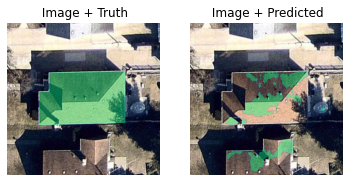

MeanIoU: 0.263  Precision: 0.676  Recall: 0.300


In [42]:
# let's test our current model and load and test that for verification
x = read_data(Path(test_x[0]), True)
y = read_data(Path(test_y[0]), True, 255., False)>0
with tf.device('/cpu:0'):
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
y_pred = y_pred[:,:,0] # mask layer
miou = np.logical_and(y, y_pred).sum()/np.logical_or(y, y_pred).sum()
prec = precision_score(y.flatten(), y_pred.flatten())
rec = recall_score(y.flatten(), y_pred.flatten())
visualize_image_and_mask(x, y, y_pred)
print(f'MeanIoU: {miou:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}')

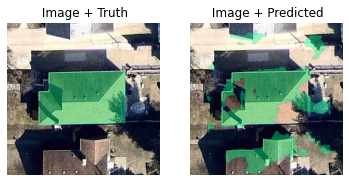

MeanIoU: 0.466  Precision: 0.539  Recall: 0.774


In [48]:
# let's load and test that for verification
model_load = tf.keras.models.load_model(save_path)
x = read_data(Path(test_x[0]), True)
y = read_data(Path(test_y[0]), True, 255., False)>0
with tf.device('/cpu:0'):
    y_pred = model_load.predict(np.expand_dims(x, axis=0))[0] > 0.5
y_pred = y_pred[:,:,0] # mask layer
miou = np.logical_and(y, y_pred).sum()/np.logical_or(y, y_pred).sum()
prec = precision_score(y.flatten(), y_pred.flatten())
rec = recall_score(y.flatten(), y_pred.flatten())
visualize_image_and_mask(x, y, y_pred)
print(f'MeanIoU: {miou:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}')

In [46]:
# looks good
save_path

WindowsPath('C:/Users/NPDan/Documents/GitHub/task_challenge/src/base_model_SigFocalCE_20210408-193627.h5')

In [49]:
y_pred.tolist()

[[False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
 